In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import jieba

## 读入评论数据

In [95]:
#data = pd.read_csv('comments.csv')
data = pd.read_csv('../Emotional-analysis-of-curriculum-review/黄忠财/newtest.csv')
data = data[:11000]

In [96]:
docs = data['comment'].tolist()

## jieba分词

In [97]:
words_list = [list(jieba.cut(doc)) for doc in docs]

1. 统计单词数<br>
2. 构建word2index字典（留出0位作为padding）

In [98]:
vocb = set([word for words in words_list for word in words])
word_to_idx = {word: (i+1) for i, word in enumerate(vocb)}
idx_to_word = {word_to_idx[word]: word for word in word_to_idx}

In [99]:
comments = []
comments_Bylist = []
for doc in docs:
    sentence = ''
    sentence_list = []
    for word in list(jieba.cut(doc)):
        if sentence == '' and sentence_list is None:
            sentence += word
            sentence_list.append(word)
        else:
            sentence += (' ' + word)
            sentence_list.append(word)
    comments.append(sentence)
    comments_Bylist.append(sentence_list)

## 统计分词后词频，并根据直方图确定合适的输入长度

In [100]:
comments_length = []
for comment in comments_Bylist:
    comments_length.append(len(comment))
print('max:',max(comments_length))
print('min:',min(comments_length))

max: 494
min: 2


(array([1.514e+03, 2.200e+03, 2.220e+03, 9.720e+02, 9.910e+02, 4.980e+02,
        5.570e+02, 2.480e+02, 3.190e+02, 1.560e+02, 2.160e+02, 1.120e+02,
        9.200e+01, 1.030e+02, 6.100e+01, 7.300e+01, 5.400e+01, 7.000e+01,
        3.300e+01, 5.500e+01, 2.700e+01, 3.500e+01, 2.400e+01, 3.000e+01,
        1.600e+01, 2.200e+01, 2.500e+01, 1.300e+01, 2.100e+01, 1.500e+01,
        1.600e+01, 1.400e+01, 1.100e+01, 9.000e+00, 1.000e+01, 7.000e+00,
        1.000e+01, 9.000e+00, 6.000e+00, 7.000e+00, 6.000e+00, 8.000e+00,
        5.000e+00, 8.000e+00, 2.000e+00, 9.000e+00, 3.000e+00, 6.000e+00,
        3.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

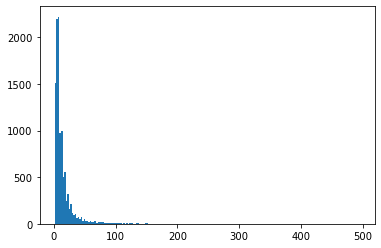

In [101]:
import matplotlib.pyplot as plt

plt.hist(comments_length,bins=200)

## word->index

In [102]:
comments_ints = []


for comment in comments_Bylist:
    item_ints = []
    for item in comment:
        #print(item)
        if item == '\n' or item == ' ':
            continue
        item_ints.append(word_to_idx[str(item).replace(' ','')])
    comments_ints.append(item_ints)


## padding
1. 根据直方图确定输入长度为12<br>
2. 不足12的comment前端用0填充；超过12的comment截取前12个词

In [103]:
import numpy as np


def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)
 
    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = reviews_ints[i][:seq_length]
    
    return features
 
 
 
# Test your implementation!
 
seq_length = 12
 
features = pad_features(comments_ints, seq_length=seq_length)
 
## test statements - do not change - ##
assert len(features)==len(comments_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."
 
# print first 10 values of the first 30 batches 
print(features[:30,:10])

[[ 1314   246  1488  6505  2688  6442  1444  8534  1050  2226]
 [ 6252   246  1062  1488  6505  7016  3474  8566  2438   246]
 [    0     0     0     0     0     0     0  7907  1444  7907]
 [ 6520  2383 10718  8600  2436  7586  7841   410  1444  5886]
 [    0     0     0     0     0     0     0     0     0  2901]
 [    0     0     0     0     0     0     0     0     0  9711]
 [    0     0     0     0     0     0     0     0  2056  2056]
 [ 9894  8802   596  5005  5483  3786  1444  5129  9153  4193]
 [    0     0     0     0     0     0     0     0  8585  1444]
 [    0     0     0     0     0     0     0     0  9899  5347]
 [ 1155  1062  2848   991  4653  4206 10248  1062  9122  8050]
 [    0     0     0     0     0     0     0  8802  9151   246]
 [    0     0     0     0     0     0  8820  2056  1444  4900]
 [    0     0     0     0     0     0  5193   564 10658  7842]
 [10108  7215  1155  4548  7015  7674  1251  5123  7892   246]
 [ 7322  7164  1444  7674  4687  4731  3129  1444  7170

## 数据集划分

In [104]:
encoded_labels = np.array(data['sentiment'].to_list())

split_frac = 0.8
 
## split data into training, validation, and test data (features and labels, x and y)
 
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]
 
test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]
 
## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(8800, 12) 
Validation set: 	(1100, 12) 
Test set: 		(1100, 12)


## 构建DataLoader，设置batch_size

In [105]:
import torch
from torch.utils.data import TensorDataset, DataLoader
 
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
 
# dataloaders
batch_size = 50
 
# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
 
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 12])
Sample input: 
 tensor([[    0,     0,     0,  7488,  7164,  1444,  8566,  1500,  7501,  9252,
          6037,  4193],
        [ 6285,  5347,  3018,  1444,  4973,  4900,  5889,  1444,  6505,  6943,
          6779,   380],
        [    0,     0,     0,     0,     0,     0,     0,     0,  9330,  2480,
          1851,  1074],
        [    0,     0,     0,     0,  7586,  3859,  2145,  3088,  5972,  5489,
          7257,  7257],
        [ 8050,    75,  6505,  2770,  4548, 10715,  6543,  3708,  9651,  9460,
          4548,  5882],
        [ 2848,  2436,  9754,   601,  9747,  5993,  2721,   246,  5975,  1444,
          5611,  7674],
        [    0,     0,  9330,  6063,  1444,  1314,   246,  9711,  1444,  7674,
          1699,  3786],
        [    0,  8050,  7015,  5563,  1444,  6884,  2743,  6770,  9030,  8050,
          8292,  6101],
        [  894,  9198,  7674,  2118,  5504,  1444,  3067,  5123,  7568,  6543,
          7185,  4193],
        [ 8382, 

## 检测GPU

In [106]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()
 
if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


## LSTM模型构建

In [107]:
import torch.nn as nn
 
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
 
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional=True, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()
 
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True,
                            bidirectional=bidirectional)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        if bidirectional:
            self.fc = nn.Linear(hidden_dim*2, output_size)
        else:
            self.fc = nn.Linear(hidden_dim, output_size)
          
        self.sig = nn.Sigmoid()
        
 
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
 
        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
#         if bidirectional:
#           lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim*2)
#         else:
#           lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
       
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        number = 1
        if self.bidirectional:
            number = 2
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_().cuda()
                     )
        else:
            hidden = (weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_()
                     )
        
        return hidden

In [108]:
# Instantiate the model w/ hyperparams
#vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
vocab_size = len(vocb)+1
output_size = 1
embedding_dim = 200
hidden_dim = 256
n_layers = 2
bidirectional = True  #这里为True，为双向LSTM
 
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional)
 
print(net)

SentimentRNN(
  (embedding): Embedding(10944, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training

In [109]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()

# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)
    counter = 0

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        #print(counter)
        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()

            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.366501... Val Loss: 0.388199
Epoch: 2/4... Step: 100... Loss: 0.154077... Val Loss: 0.336135
Epoch: 3/4... Step: 100... Loss: 0.121731... Val Loss: 0.308698
Epoch: 4/4... Step: 100... Loss: 0.236403... Val Loss: 0.356355


## Testing

In [110]:
# Get test data loss and accuracy
 
test_losses = [] # track loss
num_correct = 0
 
# init hidden state
h = net.init_hidden(batch_size)
 
net.eval()
# iterate over test data
for inputs, labels in test_loader:
 
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])
 
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
 
 
# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))
 
# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.364
Test accuracy: 0.885


## Inference

In [111]:
def review2list(content):
    words_list = list(jieba.cut(content))
    #print(words_list)
    words_ints = []
    for item in words_list:
        try:
            words_ints.append(word_to_idx[item])
        except:
            words_ints.append(0)
    return [words_ints]#size(0)=2

In [112]:
review = '这也叫网课！？老师全程照着书念我也会'
review_ints = review2list(review)
print(review_ints)

[[4183, 7240, 8570, 4989, 7463, 4844, 9330, 1175, 2145, 3088, 2848, 7240, 1085]]


In [113]:
seq_length = 12
features = pad_features(review_ints,seq_length)
feature_tensor = torch.from_numpy(features)

print(features)

[[4183 7240 8570 4989 7463 4844 9330 1175 2145 3088 2848 7240]]


In [114]:
def predict(net, test_review, sequence_length=12):
    
    net.eval()
    
    # tokenize review
    test_ints = review2list(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")

In [115]:
# call function
seq_length=12 # good to use the length that was trained on
#review = '这也叫网课！？老师全程照着书念我也会'
#review = '这也叫网课！？'
review = '念PPT辛苦了 老师'
predict(net, review, seq_length)

Prediction value, pre-rounding: 0.002144
Negative review detected.
